In [1]:
import torchvision
from torch import Tensor
from plots import plot_vae_classifier_training_result, plot_image_label

from vae.mnist_vae import VaeAutoencoderClassifier
from image_classifier.image_classifier import MNISTClassifier
from utils import frechet_inception_distance

In [2]:
training_data = torchvision.datasets.FashionMNIST(root='../data/FMNIST_train', train=True, download=True, transform=torchvision.transforms.ToTensor())
testing_data = torchvision.datasets.FashionMNIST(root='../data/FMNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())

print(training_data)
print(testing_data)

input = training_data.data[:60000] / 255.0    # normalizing necessary to make pixels in [0, 1] range for FID
labels = training_data.targets[:60000]

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../data/FMNIST_train
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../data/FMNIST_test
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
# Train VAE
vae = VaeAutoencoderClassifier(dim_encoding=3)

# works best for around alpha of 10000 and 20 epochs
vae_classifier_model, total_losses, classifier_accuracy_li, classifier_loss_li, vae_loss_li, kl_loss_li = vae.train_model(
    training_data=training_data,
    batch_size=100,
    alpha=1,
    beta=1,
    epochs=1
)

Finished epoch:  1


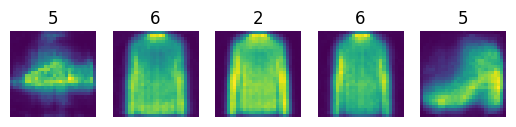

In [8]:
# plot generated data
image_tensor, label_tensor = vae.generate_data(n_samples=5)
plot_image_label(image_tensor.cpu().detach().numpy(), label_tensor.cpu().detach().numpy())

In [9]:
# move tensors to cpu before converting to np array
np_classifier_accuracy_li = []
np_classifier_loss_li = []
np_vae_loss_li = []
np_kl_loss_li = []

for output in classifier_accuracy_li:
    if isinstance(output, Tensor):
        np_classifier_accuracy_li.append(output.cpu().detach().numpy())

for output in classifier_loss_li:
    if isinstance(output, Tensor):
        np_classifier_loss_li.append(output.cpu().detach().numpy())
        
for output in vae_loss_li:
    if isinstance(output, Tensor):
        np_vae_loss_li.append(output.cpu().detach().numpy())

for output in kl_loss_li:
    if isinstance(output, Tensor):
        np_kl_loss_li.append(output.cpu().detach().numpy())


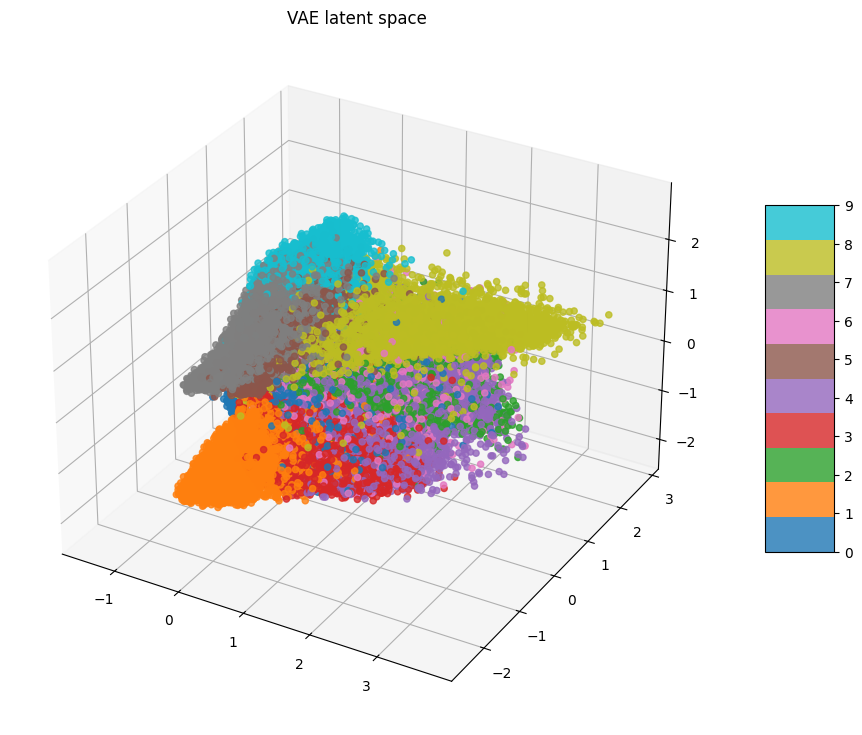

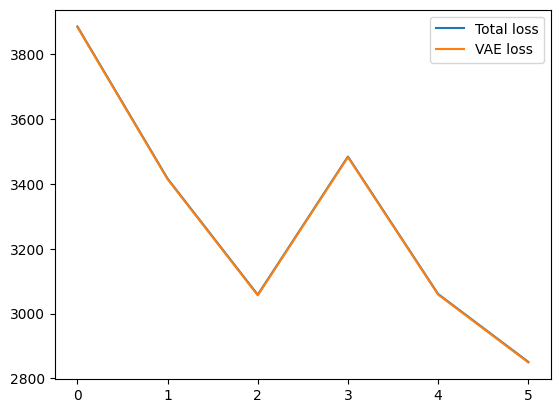

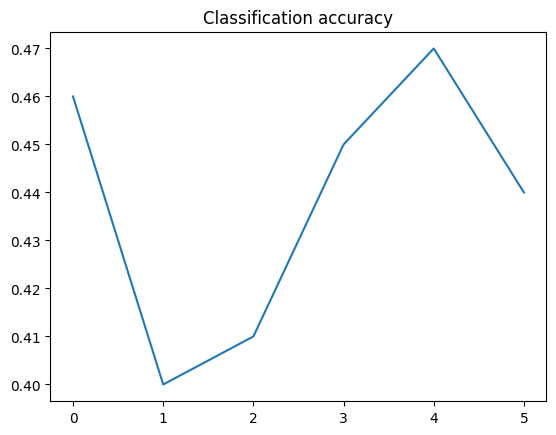

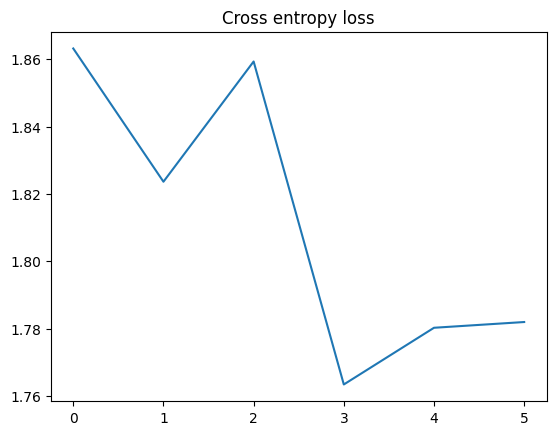

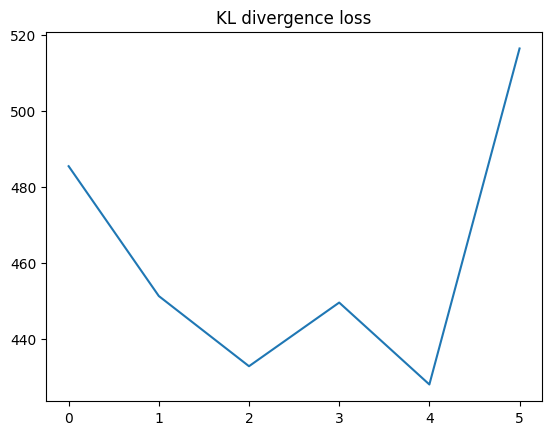

In [10]:
# plot results
plot_vae_classifier_training_result(
    input=input,
    labels=labels,
    vae_model_classifier=vae_classifier_model,
    vae_loss_li=np_vae_loss_li,
    total_losses=total_losses, 
    classifier_accuracy_li=np_classifier_accuracy_li, 
    classifier_loss_li=np_classifier_loss_li,
    kl_loss_li=np_kl_loss_li
)

In [11]:
# train classifier for performance evaluation

classifier = MNISTClassifier(input_size=784, num_classes=10)
classifier.train_model(training_data, batch_size=100, epochs=5)
accuracy = classifier.test_model(testing_data)
print("Test accuracy: ", accuracy)

Epoch done:  1
Epoch done:  2
Epoch done:  3
Epoch done:  4
Epoch done:  5
Test accuracy:  0.8677


In [12]:
x, y = vae.generate_data(n_samples=10000)

assert x.shape[0] == y.shape[0]
print("Number of images: ", x.shape[0])

Number of images:  10000


In [13]:
# test quality of images
accuracy = classifier.test_model_syn_img(x, y)
print("Accuracy: ", accuracy)


AttributeError: 'MNISTClassifier' object has no attribute 'test_model_syn_img'

In [ ]:
# Determine FID
# generate 500 images
syn_input, _ = vae.generate_data(n_samples=500)
input = input[:500]

input_rgb = input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
syn_input_rgb = syn_input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)

# compute FID score
fid_score = frechet_inception_distance(input_rgb, syn_input_rgb)
print("Frechet Inception Distance: ", fid_score)